# Homomorphic Encryption (HE) Laboratory Report

First things first we need to install 2 libraries and download repository with the dataset.
- TenSEAL is a library for doing homomorphic encryption operations on tensors, built on top of Microsoft SEAL
- Python Speach Features - is needed to extract features from audio

In [228]:
!pip install tenseal
!pip install python_speech_features
!git clone https://github.com/NescobarAlopLop/homomorhpic_lab.git

fatal: destination path 'homomorhpic_lab' already exists and is not an empty directory.


Nonthing special, just import packages

In [229]:
import codecs
import copy
import json
import os
import sys

import numpy as np
import pandas as pd
import python_speech_features as psf
import scipy.io.wavfile as sw
import tenseal as ts
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time
import tqdm

Read dataset and extract features.

In [230]:
audio_files_directory = '/content/homomorhpic_lab/model_training/training_data'


final_dataset = pd.DataFrame()

number_of_filters = 26
for file_name in os.listdir(audio_files_directory):
    if not os.path.isfile(os.path.join(audio_files_directory, file_name)):
        continue

    rate, signal = sw.read(os.path.join(audio_files_directory, file_name))
    features = psf.base.mfcc(signal=signal, samplerate=rate, preemph=1.1, nfilt=number_of_filters, numcep=17)
    features = psf.base.fbank(
        signal=features,
        samplerate=rate,
    )[1]
    features = psf.base.logfbank(features)
    features_df = pd.DataFrame(features)

    if 'dog' in file_name:
        features_df['label'] = '-1'
    elif 'cat' in file_name:
        features_df['label'] = '1'
    else:
        raise ValueError(f'Unsupported animal class {file_name}')

    final_dataset = final_dataset.append(features_df, ignore_index=True)


# Finalize dataset with the attributes and target
X = final_dataset.iloc[:, 0:-1]
y = final_dataset.iloc[:, -1]

To improve training and ease on HE computation I scale the data. And save scaling arguments for feature extraction during testing.

In [231]:
# Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=1)
train_mean = np.array(X_train.mean())
train_standard_deviation = np.array(X_train.std())

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = sc.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

print(f'Dataset shape: {final_dataset.shape}')
print(f'Features:\n{X.head(3)}')
print(f'Labels:\n{y.head(3)}')

Dataset shape: (270, 27)
Features:
          0          1          2   ...         23         24         25
0  13.000456  11.973259  12.390361  ...  15.164259  15.173839  15.076394
1  12.858563  11.260208  12.279925  ...  14.701157  14.907449  14.952418
2  14.256347  13.940965  12.712797  ...  16.274481  16.364131  17.109760

[3 rows x 26 columns]
Labels:
0    1
1    1
2    1
Name: label, dtype: object


For ease of use and future modifications I've extracted the model configurations into a separate cell.
Once changed please re-run all the following cells to get the updated results.

In [232]:
polynomial_degree = 3
C = 20
gamma = 10

Create and train SVM model
So to make in more interesting we choose polynomial kernel. As you can see t

In [233]:
model = svm.SVC(
  kernel='poly',
  degree=polynomial_degree,
  C=C,
  gamma=gamma,
)
model.fit(X_train, y_train)

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

As every datascientis and good student knows we only test quality of a trained model on part of the data we have never seen.
So here we go:

In [234]:
accuracy_score = model.score(X_test, y_test)
print(f'accuracy_score: {accuracy_score}')

accuracy_score: 0.8461538461538461


Lets run to predictions just to see if the model works

In [235]:
print(f'this should be {y_train.iloc[0]} a.k.a. cat: {model.predict(np.array(X_train.iloc[0,:]).reshape((1,26)))[0]}')
print(f'this should be {y_train.iloc[3]} a.k.a. dog: {model.predict(np.array(X_train.iloc[3,:]).reshape((1,26)))[0]}')

this should be 1 a.k.a. cat: 1
this should be -1 a.k.a. dog: -1


# Homomorphic Encryption example
We finally here, this is officially the fun part!

We have a trained SVM model, and we have some data. Which in our case are recordings of cats meow and dogs bark.
Now lets assume that for some reason we are unable to tell the two apart, but we also do not want to whoever owns the server, or the "cloud" to know what animals do we have.

So how one does it? How can we run inference on a remote server without discovering our data?

**Homomorphic encryption to the rescue!**

## This code is run on "imaginary" client side:

First we generate SEAL context.

In [236]:
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192 * 2,
    coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2**40

Now I would like to define two functions, one that loads the audio file and extracts features from it, and the other that scales the query. Since we have trained our model on scaled data so the inference should also be made on scaled inputs.

In [237]:
def load_query_from_file(
    file_path='cat_21.wav',
):
    rate, signal = sw.read(os.path.join(audio_files_directory, file_path))
    features = psf.base.mfcc(signal=signal, samplerate=rate, preemph=1.1, nfilt=number_of_filters, numcep=17)
    features = psf.base.fbank(features)[1]
    features = psf.base.logfbank(features)
    query = np.array(features)[0]

    return query

def scale_qeuery(
    query,
):
    return np.array((query - train_mean) / train_standard_deviation).reshape((1, 26))

In [238]:
query = load_query_from_file()
scaled_query = scale_qeuery(query)

Next line encrypts the query

In [239]:
enc_query = ts.ckks_vector(context, scaled_query.tolist()[0])

Now let's imagine that we've sent the encrypted query to a remote server. And the next cells are run on an "imaginary" server.


## This code is run on an "imaginary" server
To make things easier on the reader lets extract the required learned vectors from the trained model

In [240]:
bias = model.intercept_[0]
degree = model.degree
support_vectors = model.support_vectors_
gamma = model.gamma
dual_coefficients = model.dual_coef_
coef0 = model.coef0

# And so inference part:
to answer if the query is a cat or a dog we have to calculate the following on an encrypted vector:
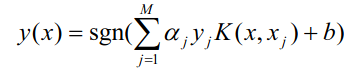

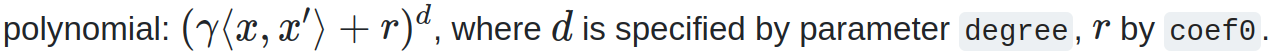

In [241]:
x_dot_x_tag = enc_query.matmul(support_vectors.T.tolist())
inner_brackets = gamma * x_dot_x_tag + coef0
poly_kernel = inner_brackets.square() * inner_brackets  # 3rd degree

prediction_enc = poly_kernel.dot(dual_coefficients[0].tolist()) + bias

At this point, our imaginary server returns the encrypted result back to the client. 

## the following code is run on the client-side:

All whats left to do is to decrypt the prediction.
For the reader let's add 2 more lines that will do the inference as it would have been done without encryption, just to compare the results:

In [242]:
decrytped_prediction = prediction_enc.decrypt()
print(f'result prediction from encrypted value:\t\t{decrytped_prediction[0]}')

prediction_using_built_in_SVM_function = model.decision_function(scaled_query)
print(f'expected prediction value:\t\t\t{prediction_using_built_in_SVM_function[0]}')

prediction_using_vector_math = dual_coefficients.dot(
    np.power(
        gamma * support_vectors.dot(scaled_query.T) + coef0,
        degree
    )
) + bias
print(f'expected prediction value using vector math:\t{decrytped_prediction[0]}')

result prediction from encrypted value:		1.4895925491528743
expected prediction value:			1.4895853602724585
expected prediction value using vector math:	1.4895925491528743


Yes! I know! The result is nothing short of amazing.

We have been able to:
- train an SVM model
- encrypt our query
- run the inference on encrypted query
- and get result identical to one without encryption

From here all client needs to do is to ask the server what is the meaning of positive and negative values (in case of 2 class classification with SVM).
And then the client can check the sign of the resulting values.

In [243]:
print(f'expected result using original model without encryption: {model.predict(scaled_query)}')
print(f'result prediction from encrypted value:\t\t\t {np.sign(prediction_enc.decrypt())}')

expected result using original model without encryption: ['1']
result prediction from encrypted value:			 [1.]


For better readability, let's wrap the server-side code into a function:

In [244]:
def server_side_computation(
    enc_query,
    support_vectors: np.array,
    coef0,
    gamma,
    bias,
    dual_coefficients
):
    x_dot_x_tag = enc_query.matmul(support_vectors.T.tolist())
    inner_brackets = gamma * x_dot_x_tag + coef0
    poly_kernel = inner_brackets.square() * inner_brackets  # 3rd degree

    return poly_kernel.dot(dual_coefficients[0].tolist()) + bias

Let us check the MSE and count the correct predictions comparing HE and unencrypted predictions on all available sound files in the dataset.
The thing to note here the MSE is tiny, negligible!
And all of the predictions are the same as the ones made on not encrypted query

Since we are only somewhat interested in the quality of the trained model and most of the emphasis goes towards featuring HE as a viable alternative for server-side inference I will run the following tests on all of the data.

**Running the following cell will take a while, about 5 minutes**

In [ ]:
correct_results_counter = 0
wrong_results_counter = 0
results = pd.DataFrame(columns=['open_text', 'HE', 'same_result', 'encryption_time', 'inference_time', 'decryption_time', 'total_encrypted_time', 'total_open_text_time'])

for features_array in tqdm.tqdm(X.iterrows(), total=len(X)):
    scaled_query = scale_qeuery(
        query=features_array[1],
    )
    now = time.time()
    enc_query = ts.ckks_vector(context, scaled_query.tolist()[0])
    encryption_time = time.time() - now

    now = time.time()
    encrypted_prediction = server_side_computation(
        enc_query=enc_query,
        support_vectors=support_vectors,
        coef0=coef0,
        gamma=gamma,
        bias=bias,
        dual_coefficients=dual_coefficients,
    )
    inference_time = time.time() - now

    now = time.time()
    decrypted_prediction = encrypted_prediction.decrypt()
    decryption_time = time.time() - now

    now = time.time()
    prediction_using_vector_math = dual_coefficients.dot(
      np.power(
          gamma * support_vectors.dot(scaled_query.T) + coef0,
          degree
      )
    ) + bias
    total_open_text_time = time.time() - now
    
    results = results.append(
        {
            'open_text': prediction_using_vector_math[0],
            'HE': decrypted_prediction,
            'same_result': np.sign(prediction_using_vector_math[0]) == np.sign(decrypted_prediction),
            'encryption_time': encryption_time,
            'inference_time': inference_time,
            'decryption_time': decryption_time,
            'total_encrypted_time': encryption_time + inference_time + decryption_time,
            'total_open_text_time': total_open_text_time,
        },
        ignore_index=True
    )

print(f'total correct: {correct_results_counter}')
print(f'total wrong: {wrong_results_counter}')
mse = ((results['open_text'] - results['HE'])**2).mean(axis=0)
print(f'MSE: {mse}')



  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 1/270 [00:01<05:37,  1.26s/it]

  1%|          | 2/270 [00:02<05:35,  1.25s/it]

  1%|          | 3/270 [00:03<05:33,  1.25s/it]

  1%|▏         | 4/270 [00:04<05:30,  1.24s/it]

  2%|▏         | 5/270 [00:06<05:28,  1.24s/it]

  2%|▏         | 6/270 [00:07<05:25,  1.23s/it]

  3%|▎         | 7/270 [00:08<05:24,  1.23s/it]

  3%|▎         | 8/270 [00:09<05:23,  1.23s/it]

  3%|▎         | 9/270 [00:11<05:22,  1.24s/it]

  4%|▎         | 10/270 [00:12<05:21,  1.24s/it]

  4%|▍         | 11/270 [00:13<05:21,  1.24s/it]

  4%|▍         | 12/270 [00:14<05:18,  1.24s/it]

  5%|▍         | 13/270 [00:16<05:17,  1.24s/it]

  5%|▌         | 14/270 [00:17<05:15,  1.23s/it]

  6%|▌         | 15/270 [00:18<05:14,  1.23s/it]

  6%|▌         | 16/270 [00:19<05:14,  1.24s/it]

  6%|▋         | 17/270 [00:21<05:12,  1.24s/it]

  7%|▋         | 18/270 [00:22<05:12,  1.24s/it]

  7%|▋         | 19/270 [00:23<05:10,  1.24s/it]

  7%|▋         |

We have finished running the comparison between encrypted and open text inference.
These are our results.
As you can see the MSE (mean squared error) is negligible, more overall the predictions on encrypted data yield exactly the same results as open text predictions.
It seems as though there are no downsides to using HE, but is there?

Nothing is free, neither is our privacy and security. Computation on encrypted data simply takes longer.

In [ ]:
results.describe()

To extract the most important information from the previous table:
- Mean time for open text inference is: 0.000148, with a standard deviation of 0.0001

- Mean time for total encrypted computation is 1.227132 with std of 0.008

This means that secure inference is about 8300 times slower than open-text one.

This number seems big and scary, but let's not forget that it's **only about a second** on a general-purpose CPU. And what's another second to wait and be sure that your privacy is intact.

With this, I would like to conclude that HE is an absolutely viable way to protect users and their data even in its current early stage of development with limited hardware support.

More information about SVM and HE can be found at the links at the bottom of this notebook.

In [ ]:
results.hist(bins=30, figsize=(20, 12))

Links:
- [More on SVM scikit learn](https://scikit-learn.org/stable/modules/svm.html)
- [More detailed overview of SVM and kernel functions](https://core.ac.uk/download/pdf/41757043.pdf)
- [dot product explanation](https://arxiv.org/pdf/2012.13552.pdf)
- [Support Vector Machines chapter from Python Data Science Handbook](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb#scrollTo=PDqscNUNJ7LV)
- [Scikit Learn SVC documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [SVM: Maximum margin separating hyperplane](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py)
- [Python data science book](https://github.com/jakevdp/PythonDataScienceHandbook)
- [using custom kernels with SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html)

- [Python speech features good place to find inspiration for feature extraction options](https://python-speech-features.readthedocs.io/en/latest/)
- [Standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)